## Chapter 8: Feature Importance

One of the most pervasive mistakes in financial research is to take some data, run it through an ML algorithm, backtest the predictions, and repeat the sequence until a nice-looking backtest shows up. Academic journals are filled with such pseudo-discoveries, and even large hedge funds constantly fall into this trap.

It typically takes about 20 such iterations to discover a (false) investment strategy subject to the standard significance level (false positive ratio) of 5%. In this chapter we will explore why such an approach is a waste of time and money, and how feature importance offers an alternative.

**Marcos' first law of backtesting:**

**Backtesting is not a research tool. Feature importance is.**


Once we have found what features are important, we can learn more by conducting a number of experiments.

- Are these features important all the time, or only in some specific environments?
- What triggers a change in importance over time?
- Can these regime switches be predicted?
- Are those important features also relevant to other related financial instruments?
- Are they relevant to other asset classes?
- What are the most relevant features across all financial instruments?
- What is the subset of features with the  highest rank correlation across the entire investment universe?



In [1]:
# Import packages
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl
from IPython.display import Image

mpl.rcParams['figure.figsize'] = (16, 6)

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Import MlFinLab tools
from mlfinlab.feature_importance.importance import (mean_decrease_impurity, mean_decrease_accuracy,
                                         single_feature_importance, plot_feature_importance)
from mlfinlab.feature_importance.orthogonal import get_orthogonal_features

from mlfinlab.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score
from mlfinlab.util.multiprocess import process_jobs
from mlfinlab.util.generate_dataset import generate_classification_dataset

In [2]:
def make_test_data(n_features=40, n_informative=10, n_redundant=10, n_samples=1000):
    X, y = generate_classification_dataset(n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, n_samples=n_samples)
            
    # We add a time index to both our samples and labels
    dt_index = pd.DatetimeIndex(pd.date_range(periods=n_samples, freq="1min", end=datetime.today()))
    X.index = dt_index
    y.index = dt_index
    
    return X, y

In [3]:
# def get_test_data(n_features=40, n_informative=10, n_redundant=10, n_samples=10000):
#     """
#     Generate a random dataset for a classification problem.
#     """
    
#     X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, random_state=0, shuffle=False)
#     date_range = pd.date_range(periods=n_samples, freq=pd.tseries.offsets.Minute(), end=datetime.today())
#     dt_index = pd.DatetimeIndex(data=date_range)
#     X = pd.DataFrame(trnsX, index=dt_index)
#     y = pd.Series(y, index=dt_index).to_frame('bin')
#     df0 = [f'I_{i}' for i in range(n_informative)] + ['R_%s' % i for i in range(n_redundant)]
#     df0 += ['N_%s' % i for i in range(n_features - len(df0))]
#     trnsX.columns = df0
#     cont['w'] = 1.0 / cont.shape[0]
#     cont['t1'] = pd.Series(cont.index, index=cont.index)

#     return trnsX, cont

In [4]:
def feature_importances(X, y, method, allow_masking_effects=False, n_splits=10):
    """
    Method to calculate MDI, MDA, and SFI feature importance.
    """

    max_features = None if allow_masking_effects else 1
    clf = DecisionTreeClassifier(criterion='entropy', max_features=max_features,
                                 class_weight='balanced', min_weight_fraction_leaf=0.0)

    clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features=1.0,
                            max_samples=1.0, oob_score=True, n_jobs=-1)
    fit = clf.fit(X, y)
    oob_score = fit.oob_score_

    cv_gen = PurgedKFold(n_splits=n_splits, samples_info_sets=pd.Series(y.index, index=y.index))
    oos_score = ml_cross_val_score(clf, X, y, cv_gen=cv_gen,
                                   scoring=accuracy_score, require_proba=False).mean()

    if method == 'MDI':
        imp = mean_decrease_impurity(fit, X.columns)
    elif method == 'MDA':
        imp = mean_decrease_accuracy(clf, X, y, cv_gen, scoring=accuracy_score, require_proba=False)
    elif method == 'SFI':
        imp = single_feature_importance(clf, X, y, cv_gen, scoring=accuracy_score, require_proba=False)
    
    return imp, oob_score, oos_score


def test_data_func(X, y, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    """
    Method to calculate MDI, MDA, and SFI feature importance with plotting.
    """

    for method in methods:
        feature_imp, oob_score, oos_score = feature_importances(X, y, method, allow_masking_effects)

        plot_feature_importance(feature_imp, oob_score=oob_score, oos_score=oos_score,
                                save_fig=True, output_path='images/{}_feat_imp{}.png'.format(method, run))

Generate a dataset $(X, y)$

In [5]:
X, y = make_test_data(n_features=12, n_informative=4, n_redundant=4, n_samples=300)

In [6]:
X.head()

,I_0,I_1,I_2,I_3,N_0,N_1,N_2,N_3,R_0,R_1,R_2,R_3
2023-05-30 09:51:50.580390,-1.461435,-3.259140,-0.873953,3.329074,0.088389,-0.177068,0.733894,0.867819,-1.461435,3.329074,-3.259140,-1.461435
2023-05-30 09:52:50.580390,-0.303242,-0.133859,-1.177818,0.726711,-0.150741,-1.154609,-1.614361,-1.453265,-0.303242,0.726711,-0.133859,-0.303242
2023-05-30 09:53:50.580390,-1.156336,0.802849,-1.394459,0.263851,-1.021484,0.737634,0.319999,1.092688,-1.156336,0.263851,0.802849,-1.156336
2023-05-30 09:54:50.580390,-1.820970,2.251769,-1.153326,-0.342610,-0.794358,0.733720,0.670218,0.501350,-1.820970,-0.342610,2.251769,-1.820970
2023-05-30 09:55:50.580390,-0.540018,-1.919059,-1.089877,1.681576,-0.456125,0.040553,0.922115,-1.720215,-0.540018,1.681576,-1.919059,-0.540018


In [7]:
y.head()

2023-05-30 09:51:50.580390    0
2023-05-30 09:52:50.580390    0
2023-05-30 09:53:50.580390    0
2023-05-30 09:54:50.580390    0
2023-05-30 09:55:50.580390    0
Freq: T, dtype: int64

Apply a PCA transformation on X:

In [8]:
X_pca = pd.DataFrame(get_orthogonal_features(X), index=X.index).add_prefix("PCA_")
X_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
2023-05-30 09:51:50.580390,-2.235860,-3.763902,-0.701775,1.241025,-0.151394,-0.990661,-0.088189,-0.848514
2023-05-30 09:52:50.580390,0.097339,-0.718047,1.715100,-0.872873,1.066259,-0.582397,-0.597617,0.914400
2023-05-30 09:53:50.580390,1.418845,-0.874766,-1.824041,-0.293595,-0.064174,-0.339565,-0.204219,0.990928
2023-05-30 09:54:50.580390,3.042638,-0.543448,-1.523155,-0.046793,-0.385346,-0.099890,-0.770337,1.429696
2023-05-30 09:55:50.580390,-1.333010,-1.868600,0.599389,-0.214792,-1.344618,-0.405342,-1.318990,-0.138189



Compute MDI, MDA, and SFI feature importance:

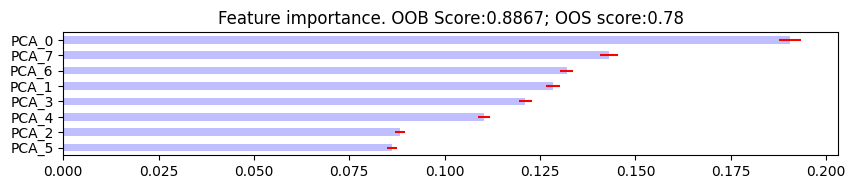

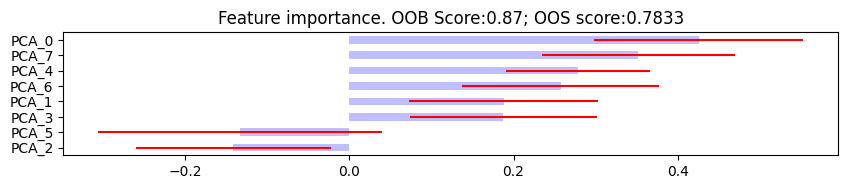

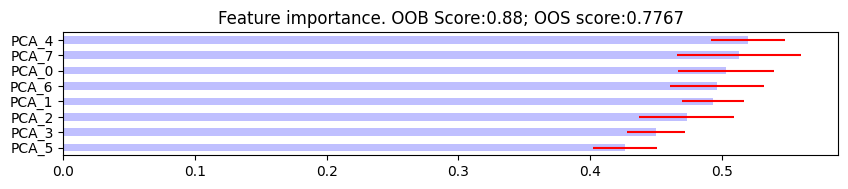

In [9]:
test_data_func(X_pca, y, '_8.1c')

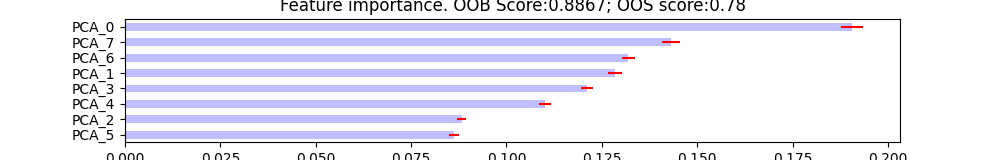

In [10]:
Image(filename='images/MDI_feat_imp_8.1c.png')

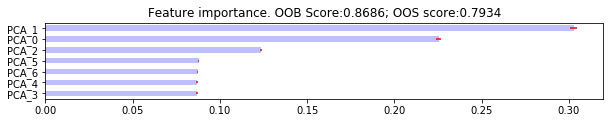

In [11]:
Image(filename='images/MDI_feat_imp_8.1c2.png')

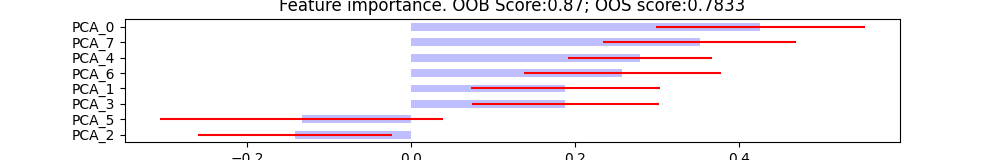

In [12]:
Image(filename='images/MDA_feat_imp_8.1c.png')

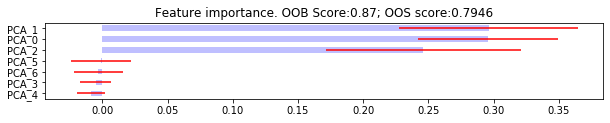

In [13]:
Image(filename='images/MDA_feat_imp_8.1c2.png')

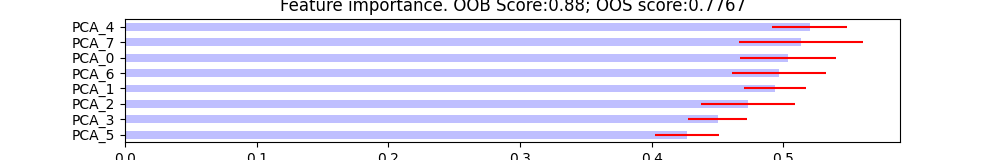

In [14]:
Image(filename='images/SFI_feat_imp_8.1c.png')

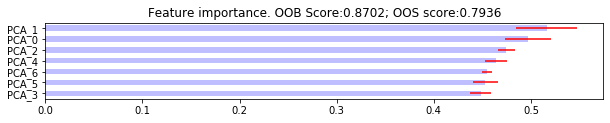

In [15]:
Image(filename='images/SFI_feat_imp_8.1c2.png')

Generate a new dataset which is a feature union of the previous two.

Then, ompute MDI, MDA, and SFI feature importance on this dataset.

In [16]:
X_joined = pd.concat([X, X_pca], axis=1)

In [ ]:
test_data_func(X_joined, y, '_8.2a')

In [ ]:
Image(filename='images/MDI_feat_imp_8.2a.png')

In [ ]:
Image(filename='images/MDA_feat_imp_8.2a.png')

In [ ]:
Image(filename='images/SFI_feat_imp_8.2a.png')